# Simple machine learning
Let us explore some of the simplest machine learning methods. We will explore principal component analysis (PCA) and k-means. They are not based on neural networks but they are still of very much use in science.

In [ ]:
!wget https://cloud.iac.es/index.php/s/32CrsctCFHpe6gX/download/quiet.h5

--2024-08-14 12:34:21--  https://cloud.iac.es/index.php/s/32CrsctCFHpe6gX/download/quiet.h5
Resolving cloud.iac.es (cloud.iac.es)... 161.72.1.33, 2001:720:1610:5001::21
Connecting to cloud.iac.es (cloud.iac.es)|161.72.1.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17922048 (17M) [application/octet-stream]
Saving to: ‘quiet.h5’

quiet.h5            100%[===================>]  17.09M  11.1MB/s    in 1.5s    

2024-08-14 12:34:23 (11.1 MB/s) - ‘quiet.h5’ saved [17922048/17922048]



In [ ]:
!wget https://cloud.iac.es/index.php/s/NkCKkCopYaEGiYM/download/wavelengthHinode.dat

--2024-08-14 12:37:11--  https://cloud.iac.es/index.php/s/NkCKkCopYaEGiYM/download/wavelengthHinode.dat
Resolving cloud.iac.es (cloud.iac.es)... 161.72.1.33, 2001:720:1610:5001::21
Connecting to cloud.iac.es (cloud.iac.es)|161.72.1.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1903 (1.9K) [application/octet-stream]
Saving to: ‘wavelengthHinode.dat’

wavelengthHinode.da 100%[===================>]   1.86K  --.-KB/s    in 0s      

2024-08-14 12:37:12 (56.4 MB/s) - ‘wavelengthHinode.dat’ saved [1903/1903]



Let us first start by importing some packages. We will carry out PCA by hand and k-means using `scikit-learn`. We also import `PyTorch` for training neural networks. However, you can do all that is shown here programming the algorithms by yourself.

In [ ]:
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import h5py
from sklearn.cluster import KMeans
import torch
import torch.utils.data
import torch.nn as nn
from tqdm import tqdm
from collections import OrderedDict

## The data
We have an HDF5 file that contains observations of a quiet Sun field of view with Hinode. We will only use the intensity profiles but what I show here can be applied to the rest of Stokes profiles or to other observations.

In [ ]:
f = h5py.File('quiet.h5', 'r')
stokes = f['stokesI'][:]
f.close()

We also read the wavelength axis of the Hinode SP.

In [ ]:
wvl = np.loadtxt('wavelengthHinode.dat')
print(wvl)

[6300.8921 6300.9136 6300.9351 6300.9561 6300.9775 6300.999  6301.0205
 6301.042  6301.0635 6301.0845 6301.106  6301.1274 6301.1489 6301.1704
 6301.1914 6301.2129 6301.2344 6301.2559 6301.2773 6301.2988 6301.3198
 6301.3413 6301.3628 6301.3843 6301.4058 6301.4268 6301.4482 6301.4697
 6301.4912 6301.5127 6301.5342 6301.5552 6301.5767 6301.5981 6301.6196
 6301.6411 6301.6621 6301.6836 6301.7051 6301.7266 6301.748  6301.7695
 6301.7905 6301.812  6301.8335 6301.855  6301.8765 6301.8975 6301.9189
 6301.9404 6301.9619 6301.9834 6302.0049 6302.0259 6302.0474 6302.0688
 6302.0903 6302.1118 6302.1328 6302.1543 6302.1758 6302.1973 6302.2188
 6302.2402 6302.2612 6302.2827 6302.3042 6302.3257 6302.3472 6302.3682
 6302.3896 6302.4111 6302.4326 6302.4541 6302.4751 6302.4966 6302.5181
 6302.5396 6302.561  6302.5825 6302.6035 6302.625  6302.6465 6302.668
 6302.6895 6302.7104 6302.7319 6302.7534 6302.7749 6302.7964 6302.8179
 6302.8389 6302.8604 6302.8818 6302.9033 6302.9248 6302.9458 6302.9673
 6302.9

Let us compute the average continuum intensity and normalize all data to this value.

In [ ]:
cont = np.mean(stokes[:, :, 0])
stokes /= cont
nx, ny, nl = stokes.shape

Now we show the field of view. On the left, a wavelength in the continuum. On the right, a wavelength close to the core of the 6301.5 A line. You can see the difference in appearance because the two wavelengths are sampling different heights in the atmosphere.

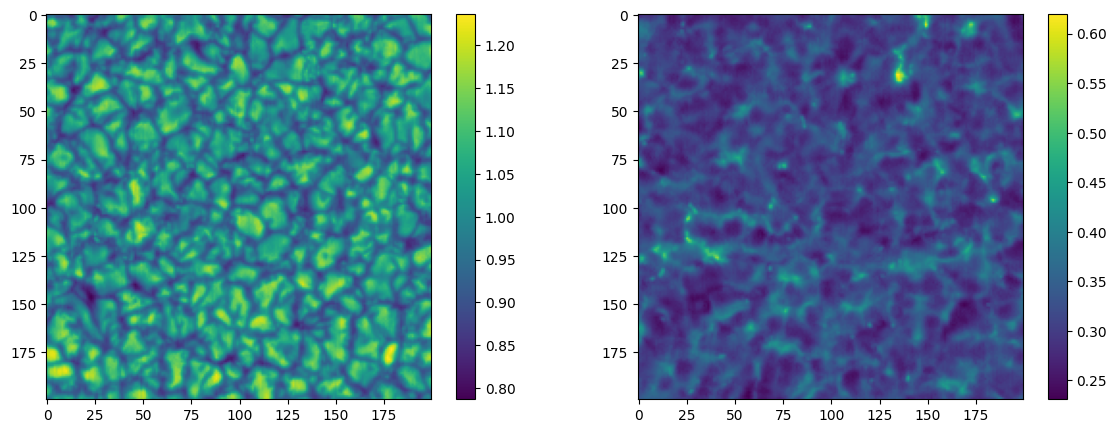

In [ ]:
fig, ax = pl.subplots(nrows=1, ncols=2, figsize=(14,5))
im = ax[0].imshow(stokes[:, :, 0])
pl.colorbar(im, ax=ax[0])
im = ax[1].imshow(stokes[:, :, 29])
pl.colorbar(im, ax=ax[1])

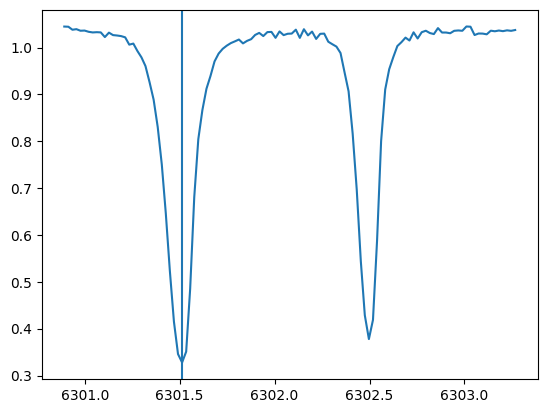

In [ ]:
fig, ax = pl.subplots()
ax.plot(wvl, stokes[75, 75, :])
ax.axvline(wvl[29])

## PCA
The PCA technique tries to find a linear transformation of the data onto a new coordinate system such that the directions (principal components) capturing the largest variation in the data can be easily identified. The PCA decomposition can be obtained by doing the singular value decomposition of the $S \times M$ data matrix, with $S$ being the length of each observation and $M$ the number of observations. A more efficient way of doing it is computing the correlation matrix of smallest dimension (among $S \times S$ and $M \times M$) and doing the SVD of this matrix. The eigenfunctions will be the same while the eigenvalues will be those of the original matrix squared.

In [ ]:
mat = stokes.reshape((nx*ny, nl))
cov = mat.T @ mat
U, S, Vh = np.linalg.svd(cov)

Let's draw some eigenfunctions:

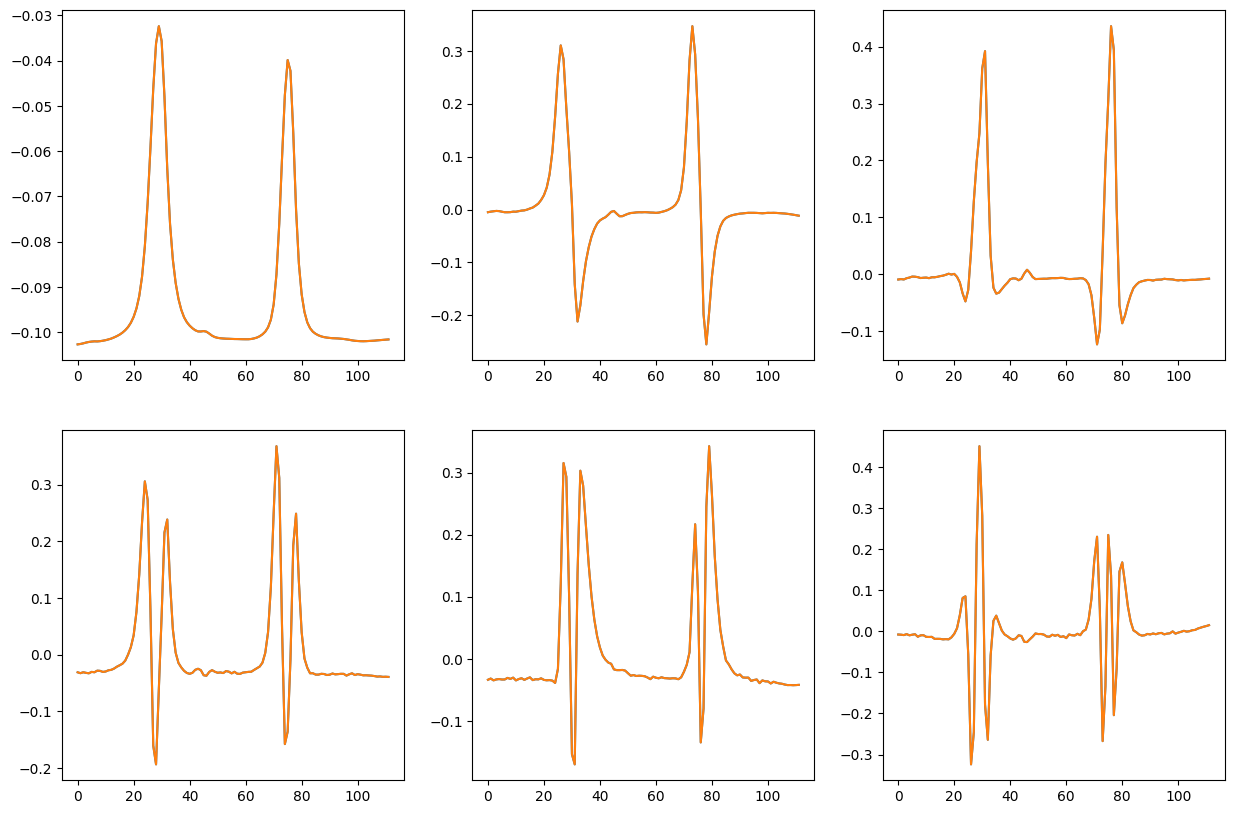

In [ ]:
fig, ax = pl.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i in range(6):
    ax.flat[i].plot(Vh[i, :])
    ax.flat[i].plot(U[:, i])

The first eigenvector is roughly equal to the average profile because we did not substract the mean. The following ones are roughly similar to derivatives of higher order of the profiles.

(40000, 112)


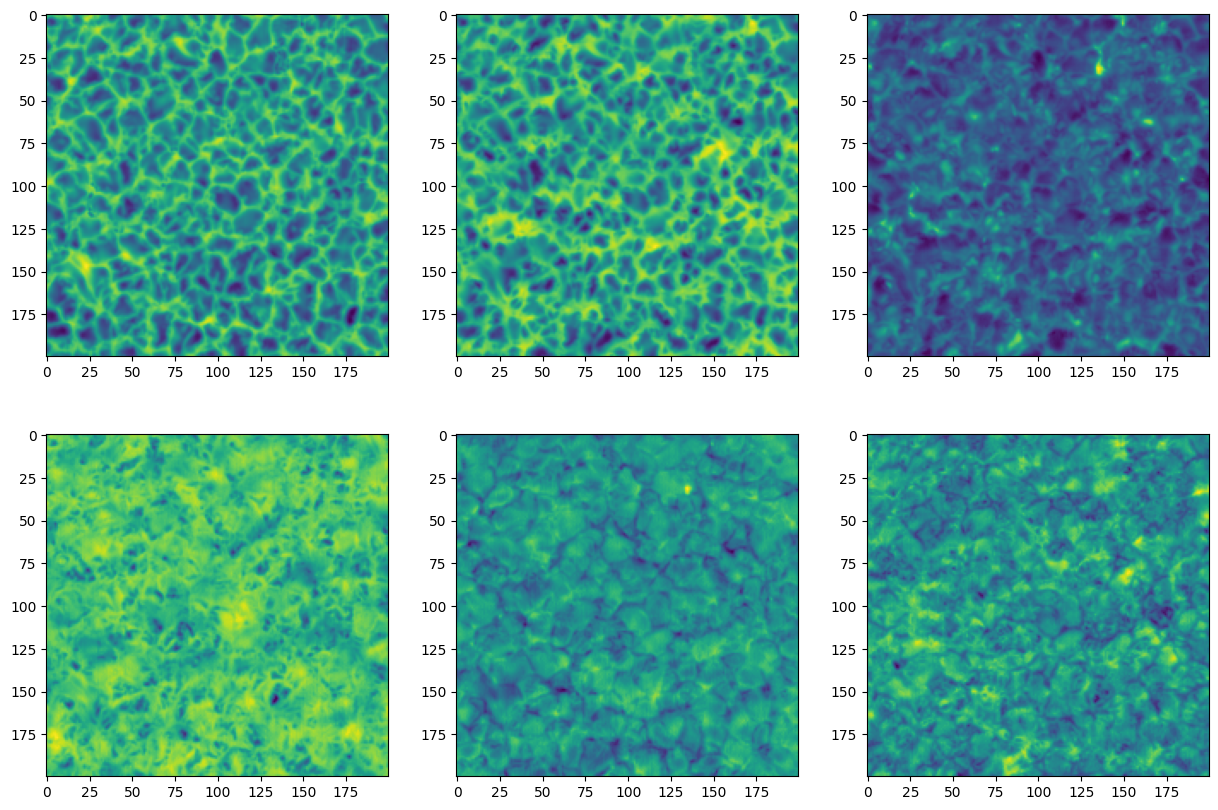

In [ ]:
coef = mat @ Vh.T
print(coef.shape)

fig, ax = pl.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i in range(6):
    ax.flat[i].imshow(coef[:, i].reshape((nx, ny)))

<figure>
<center>
<img width="400" src='https://miro.medium.com/v2/resize:fit:4800/format:webp/1*BgPLcocaAsS0AH2fEWlNmA.png' />
</center>
</figure>

**According to the appearance of the image of coefficients and the shape of the eigenprofiles, can you assign approximate physical interpretations to the coefficients?**

### Denoising
One of the most straightforward uses of PCA is denoising. For this purpose, we clamp the eigenbasis using only $K$ eigenvectors and reconstruct back the profiles. Since PCA orders eigenvectors by the amount of variance explained by them, the final eigenvectors are simply used to explain noise.

(200, 200, 112)


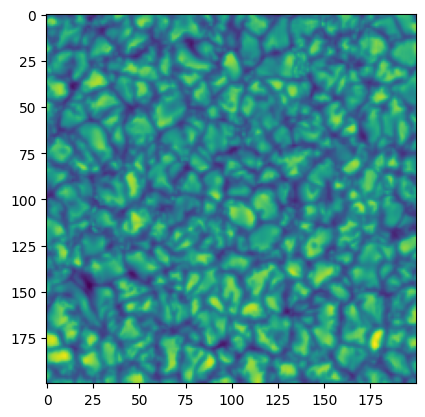

In [ ]:
npca = 5
Vh_crop = Vh[0:npca, :]
coef = mat @ Vh_crop.T
reconstructed = coef @ Vh_crop
reconstructed = reconstructed.reshape((nx, ny, nl))
print(reconstructed.shape)
pl.imshow(reconstructed[:, :, 0])

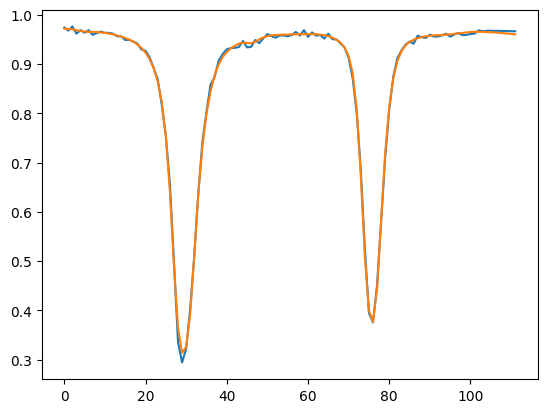

In [ ]:
pl.plot(stokes[100, 100, :])
pl.plot(reconstructed[100, 100, :])

<figure>
<center>
<img width="400" src='https://miro.medium.com/v2/resize:fit:4800/format:webp/1*BgPLcocaAsS0AH2fEWlNmA.png' />
</center>
</figure>

**How would you select the optimal number of eigenfunctions to keep?**

## k-means
k-means is an unsupervised clustering/classification method that is often used in Solar Physics. The aim is partition $n$ observations into $k$ clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster.

Let us use `scikit-learn` to carry out the experiments. We cluster the previous observations into 2, 3 and 5 clusters.

In [ ]:
kmeans2 = KMeans(n_clusters=2, random_state=0, n_init="auto")
kmeans3 = KMeans(n_clusters=3, random_state=0, n_init="auto")
kmeans5 = KMeans(n_clusters=5, random_state=0, n_init="auto")

In [ ]:
kmeans2.fit(mat)
kmeans3.fit(mat)
kmeans5.fit(mat)

KMeans(n_clusters=5, n_init='auto', random_state=0)

Text(0.5, 1.0, 'k-means 5 classes')

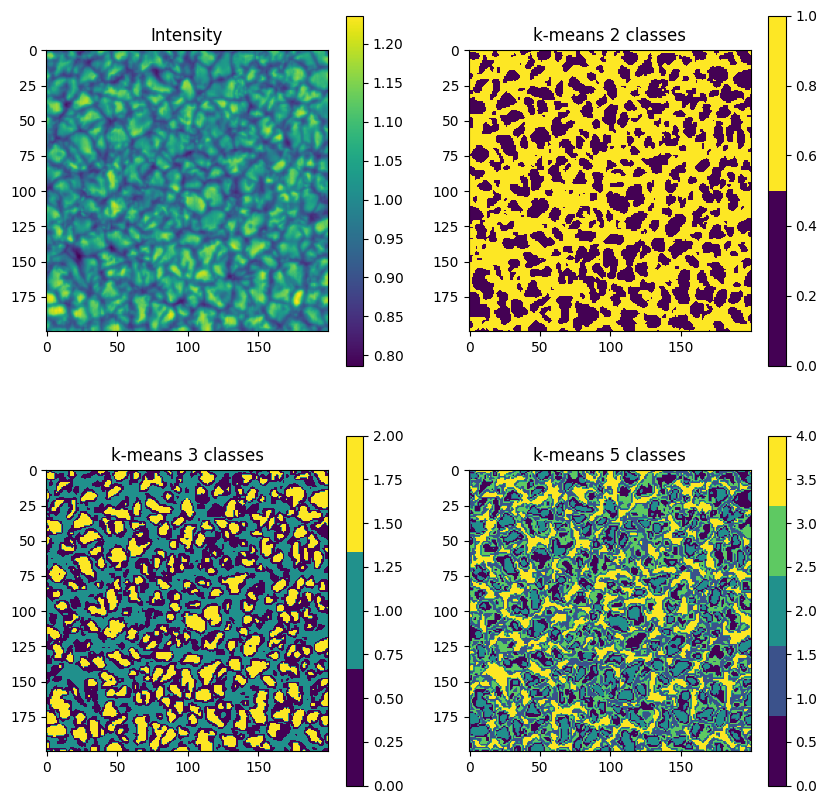

In [ ]:
labels2 = kmeans2.labels_.reshape((nx, ny))
labels3 = kmeans3.labels_.reshape((nx, ny))
labels5 = kmeans5.labels_.reshape((nx, ny))

fig, ax = pl.subplots(nrows=2, ncols=2, figsize=(10, 10))
im = ax[0, 0].imshow(stokes[:, :, 0])
pl.colorbar(im, ax=ax[0, 0])
ax[0, 0].set_title('Intensity')
im = ax[0, 1].imshow(labels2, cmap=mpl.colormaps['viridis'].resampled(2))
pl.colorbar(im, ax=ax[0, 1])
ax[0, 1].set_title('k-means 2 classes')
im = ax[1, 0].imshow(labels3, cmap=mpl.colormaps['viridis'].resampled(3))
pl.colorbar(im, ax=ax[1, 0])
ax[1, 0].set_title('k-means 3 classes')
im = ax[1, 1].imshow(labels5, cmap=mpl.colormaps['viridis'].resampled(5))
pl.colorbar(im, ax=ax[1, 1])
ax[1, 1].set_title('k-means 5 classes')

We show now the representative profiles of the cluster centers:

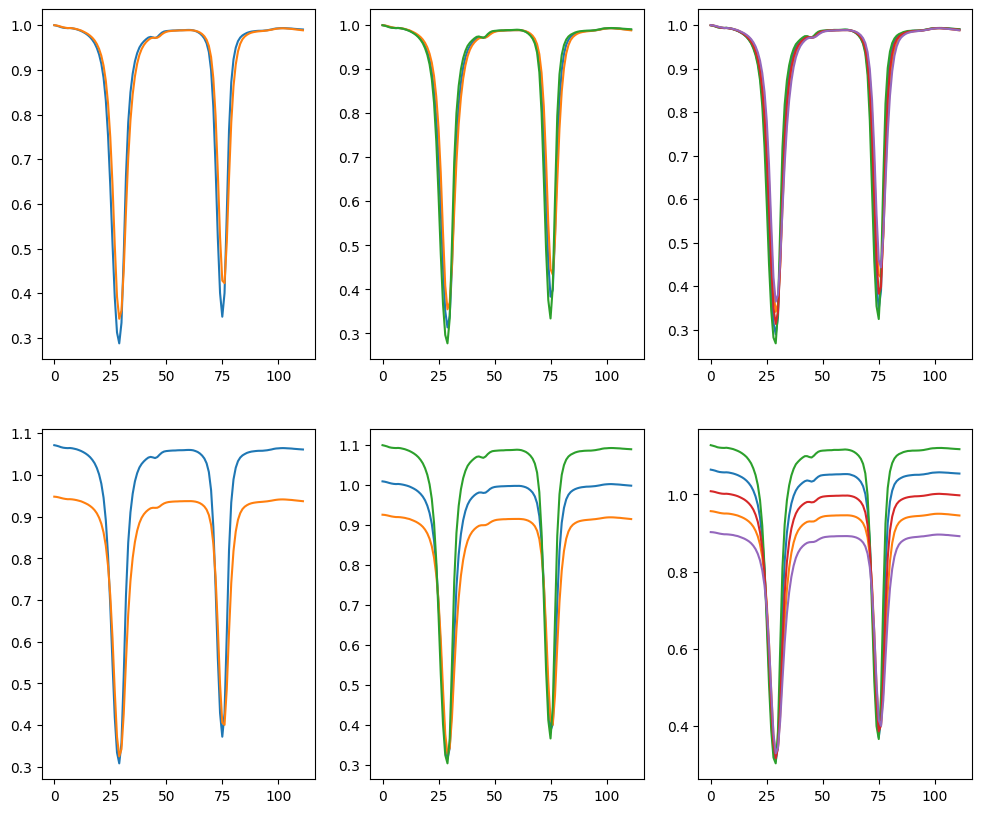

In [ ]:
fig, ax = pl.subplots(nrows=2, ncols=3, figsize=(12, 10))
for i in range(2):
    ax[0, 0].plot(kmeans2.cluster_centers_[i, :] / kmeans2.cluster_centers_[i, 0])
    ax[1, 0].plot(kmeans2.cluster_centers_[i, :])
for i in range(3):
    ax[0, 1].plot(kmeans3.cluster_centers_[i, :] / kmeans3.cluster_centers_[i, 0])
    ax[1, 1].plot(kmeans3.cluster_centers_[i, :])
for i in range(5):
    ax[0, 2].plot(kmeans5.cluster_centers_[i, :] / kmeans5.cluster_centers_[i, 0])
    ax[1, 2].plot(kmeans5.cluster_centers_[i, :])

## Simple neural network
We will consider now a simple neural network to regress some data and show how it can be trained using PyTorch.
First, we define the data we want to fit. They are Gaussian spectral lines with random amplitude and width. The neural network takes the observations (100 spectral points) and produces, as output, the amplitude and width of the lines. Let us first define the training set and do some plots. They are encapsulated in PyTorch Datasets.

In [ ]:
class Dataset(torch.utils.data.Dataset):
    """
    Dataset class that will provide data during training. Modify it accordingly
    for your dataset. This one shows how to do augmenting during training for a
    very simple training set
    """
    def __init__(self, n_training):
        """
        Very simple training set made of 200 Gaussians of width between 0.5 and 1.5
        We later augment this with a velocity and amplitude.

        Args:
            n_training (int): number of training examples including augmenting
        """
        super(Dataset, self).__init__()

        self.n_training = n_training

        x = np.linspace(-5.0, 5.0, 100)
        self.sigma = 1.0 * np.random.rand(200) + 0.5
        self.y = np.exp(-x[None,:]**2 / self.sigma[:,None]**2)

        self.indices = np.random.randint(low=0, high=200, size=self.n_training)
        self.amplitude = 2.0 * np.random.rand(self.n_training) + 0.1

    def __getitem__(self, index):

        amplitude = self.amplitude[index]
        sigma = self.sigma[self.indices[index]]

        inp = amplitude * self.y[self.indices[index],:] + 0.05 * np.random.randn(100)

        out = np.array([sigma, amplitude])

        return inp.astype('float32'), out.astype('float32')

    def __len__(self):
        return self.n_training

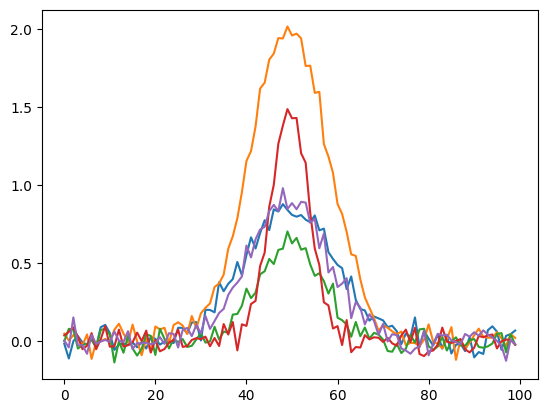

In [ ]:
dataset = Dataset(n_training=100)
fig, ax = pl.subplots()
for i in range(5):
  inp, out = dataset.__getitem__(i)
  ax.plot(inp)

Now we define the architecture of the neural network. It will be a fully-connected network with one input layer of size 100 (number of wavelength points in the lines), two hidden layer with n_hidden neurons and an output layer with n_output neurons. All neurons are connected with ReLU activation functions.

In [ ]:
class Network(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(Network, self).__init__()

        self.C1 = nn.Linear(n_input, n_hidden)
        self.C2 = nn.Linear(n_hidden, n_hidden)
        self.C3 = nn.Linear(n_hidden, n_output)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.C1(x)
        out = self.relu(out)
        out = self.C2(out)
        out = self.relu(out)
        out = self.C3(out)

        return out

Now we define the training loop. We first instantiate `DataLoader`s that will provide the training data splitting them in batches. We also instantiate an optimizer and the loss function, that we assume to be the mean square error. The `train` function goes through all training data and modifies the neural network after every batch using the gradient-descent-based `Adam` optimizer. The `test` function goes through the validation data and checks the current capabilities of the network.

In [ ]:
class Training(object):
    def __init__(self, hyperparameters):

        self.hyperparameters = hyperparameters

        self.cuda = torch.cuda.is_available()
        self.gpu = hyperparameters['gpu']
        self.smooth = hyperparameters['smooth']
        self.device = torch.device(f"cuda:{self.gpu}" if self.cuda else "cpu")

        self.batch_size = hyperparameters['batch_size']

        kwargs = {'num_workers': 2, 'pin_memory': False} if self.cuda else {}

        self.model = Network(n_input=self.hyperparameters['n_input'],
                                n_hidden=self.hyperparameters['n_hidden'],
                                n_output=self.hyperparameters['n_output']).to(self.device)

        print('N. total parameters : {0}'.format(sum(p.numel() for p in self.model.parameters() if p.requires_grad)))


        self.train_dataset = Dataset(n_training=1000)
        self.validation_dataset = Dataset(n_training=100)

        # Data loaders that will inject data during training
        self.train_loader = torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=False, **kwargs)
        self.validation_loader = torch.utils.data.DataLoader(self.validation_dataset, batch_size=self.batch_size, shuffle=False, **kwargs)

        self.lr = hyperparameters['lr']
        self.wd = hyperparameters['wd']
        self.n_epochs = hyperparameters['n_epochs']

        print('Learning rate : {0}'.format(self.lr))

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.wd)
        self.loss_fn = nn.MSELoss().to(self.device)

        # self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=scheduler, gamma=0.5)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, self.n_epochs, eta_min=0.1*self.lr)

    def optimize(self):
        self.loss = []
        self.loss_val = []
        best_loss = 1e100

        for epoch in range(1, self.n_epochs + 1):
            loss = self.train(epoch)
            loss_val = self.test()

            #self.scheduler.step()

    def train(self, epoch):
        self.model.train()
        print("Epoch {0}/{1}".format(epoch, self.n_epochs))
        t = tqdm(self.train_loader)
        loss_avg = 0.0

        for param_group in self.optimizer.param_groups:
            current_lr = param_group['lr']

        for batch_idx, (inputs, outputs) in enumerate(t):
            inputs = inputs.to(self.device)
            outputs = outputs.to(self.device)

            self.optimizer.zero_grad()
            out = self.model(inputs)

            # Loss
            loss = self.loss_fn(out, outputs)

            loss.backward()

            self.optimizer.step()

            if (batch_idx == 0):
                loss_avg = loss.item()
            else:
                loss_avg = self.smooth * loss.item() + (1.0 - self.smooth) * loss_avg

            tmp = OrderedDict()
            tmp['lr'] = current_lr
            tmp['loss'] = loss_avg
            t.set_postfix(ordered_dict = tmp)

        self.loss.append(loss_avg)

        return loss_avg

    def test(self):
        self.model.eval()
        t = tqdm(self.validation_loader)
        loss_avg = 0.0

        with torch.no_grad():
            for batch_idx, (inputs, outputs) in enumerate(t):
                inputs = inputs.to(self.device)
                outputs = outputs.to(self.device)

                out = self.model(inputs)

                # Loss
                loss = self.loss_fn(out, outputs)

                if (batch_idx == 0):
                    loss_avg = loss.item()
                else:
                    loss_avg = self.smooth * loss.item() + (1.0 - self.smooth) * loss_avg

                t.set_postfix(loss=loss_avg)

        return loss_avg

We define the hyperparameters and train the network.

In [ ]:
hyperparameters = {
        'batch_size': 64,
        'validation_split': 0.2,
        'gpu': 0,
        'lr': 3e-4,
        'wd': 0.0,
        'n_epochs': 50,
        'smooth': 0.15,
        'n_input': 100,
        'n_hidden': 40,
        'n_output': 2
    }

deepnet = Training(hyperparameters)
deepnet.optimize()

N. total parameters : 5762
Learning rate : 0.0003
Epoch 1/50


100%|██████████| 2/2 [00:00<00:00, 180.50it/s, loss=1.42]


Epoch 2/50


100%|██████████| 2/2 [00:00<00:00, 201.97it/s, loss=1.19]


Epoch 3/50


100%|██████████| 2/2 [00:00<00:00, 161.04it/s, loss=0.917]


Epoch 4/50


100%|██████████| 2/2 [00:00<00:00, 198.35it/s, loss=0.593]


Epoch 5/50


100%|██████████| 2/2 [00:00<00:00, 161.14it/s, loss=0.294]


Epoch 6/50


100%|██████████| 2/2 [00:00<00:00, 160.61it/s, loss=0.14]


Epoch 7/50


100%|██████████| 2/2 [00:00<00:00, 166.29it/s, loss=0.114]


Epoch 8/50


100%|██████████| 2/2 [00:00<00:00, 189.97it/s, loss=0.103]


Epoch 9/50


100%|██████████| 2/2 [00:00<00:00, 187.00it/s, loss=0.0963]


Epoch 10/50


100%|██████████| 2/2 [00:00<00:00, 162.80it/s, loss=0.0875]


Epoch 11/50


100%|██████████| 2/2 [00:00<00:00, 165.74it/s, loss=0.0785]


Epoch 12/50


100%|██████████| 2/2 [00:00<00:00, 143.55it/s, loss=0.0687]


Epoch 13/50


100%|██████████| 2/2 [00:00<00:00, 154.15it/s, loss=0.0608]


Epoch 14/50


100%|██████████| 2/2 [00:00<00:00, 105.83it/s, loss=0.0528]


Epoch 15/50


100%|██████████| 2/2 [00:00<00:00, 114.80it/s, loss=0.0466]


Epoch 16/50


100%|██████████| 2/2 [00:00<00:00, 156.15it/s, loss=0.0394]


Epoch 17/50


100%|██████████| 2/2 [00:00<00:00, 154.25it/s, loss=0.0339]


Epoch 18/50


100%|██████████| 2/2 [00:00<00:00, 123.21it/s, loss=0.0304]


Epoch 19/50


100%|██████████| 2/2 [00:00<00:00, 191.93it/s, loss=0.0273]


Epoch 20/50


100%|██████████| 2/2 [00:00<00:00, 158.80it/s, loss=0.0241]


Epoch 21/50


100%|██████████| 2/2 [00:00<00:00, 152.96it/s, loss=0.0215]


Epoch 22/50


100%|██████████| 2/2 [00:00<00:00, 136.97it/s, loss=0.0202]


Epoch 23/50


100%|██████████| 2/2 [00:00<00:00, 198.14it/s, loss=0.0185]


Epoch 24/50


100%|██████████| 2/2 [00:00<00:00, 183.59it/s, loss=0.0172]


Epoch 25/50


100%|██████████| 2/2 [00:00<00:00, 195.41it/s, loss=0.0161]


Epoch 26/50


100%|██████████| 2/2 [00:00<00:00, 116.88it/s, loss=0.0139]


Epoch 27/50


100%|██████████| 2/2 [00:00<00:00, 127.01it/s, loss=0.0123]


Epoch 28/50


100%|██████████| 2/2 [00:00<00:00, 156.17it/s, loss=0.0117]


Epoch 29/50


100%|██████████| 2/2 [00:00<00:00, 102.08it/s, loss=0.0109]


Epoch 30/50


100%|██████████| 2/2 [00:00<00:00, 190.06it/s, loss=0.00872]


Epoch 31/50


100%|██████████| 2/2 [00:00<00:00, 153.42it/s, loss=0.00909]


Epoch 32/50


100%|██████████| 2/2 [00:00<00:00, 123.25it/s, loss=0.00825]


Epoch 33/50


100%|██████████| 2/2 [00:00<00:00, 126.90it/s, loss=0.00802]


Epoch 34/50


100%|██████████| 2/2 [00:00<00:00, 145.51it/s, loss=0.00781]


Epoch 35/50


100%|██████████| 2/2 [00:00<00:00, 132.18it/s, loss=0.00738]


Epoch 36/50


100%|██████████| 2/2 [00:00<00:00, 166.07it/s, loss=0.00672]


Epoch 37/50


100%|██████████| 2/2 [00:00<00:00, 111.80it/s, loss=0.00669]


Epoch 38/50


100%|██████████| 2/2 [00:00<00:00, 159.13it/s, loss=0.00582]


Epoch 39/50


100%|██████████| 2/2 [00:00<00:00, 120.54it/s, loss=0.00587]


Epoch 40/50


100%|██████████| 2/2 [00:00<00:00, 123.20it/s, loss=0.00609]


Epoch 41/50


100%|██████████| 2/2 [00:00<00:00, 112.13it/s, loss=0.00499]


Epoch 42/50


100%|██████████| 2/2 [00:00<00:00, 132.29it/s, loss=0.00496]


Epoch 43/50


100%|██████████| 2/2 [00:00<00:00, 150.13it/s, loss=0.00449]


Epoch 44/50


100%|██████████| 2/2 [00:00<00:00, 143.06it/s, loss=0.00433]


Epoch 45/50


100%|██████████| 2/2 [00:00<00:00, 127.83it/s, loss=0.00391]


Epoch 46/50


100%|██████████| 2/2 [00:00<00:00, 89.55it/s, loss=0.00381]


Epoch 47/50


100%|██████████| 2/2 [00:00<00:00, 137.51it/s, loss=0.00393]


Epoch 48/50


100%|██████████| 2/2 [00:00<00:00, 171.38it/s, loss=0.00352]


Epoch 49/50


100%|██████████| 2/2 [00:00<00:00, 192.38it/s, loss=0.00361]


Epoch 50/50


100%|██████████| 2/2 [00:00<00:00, 163.37it/s, loss=0.00342]


Now we evaluate the network and compare with the real values.

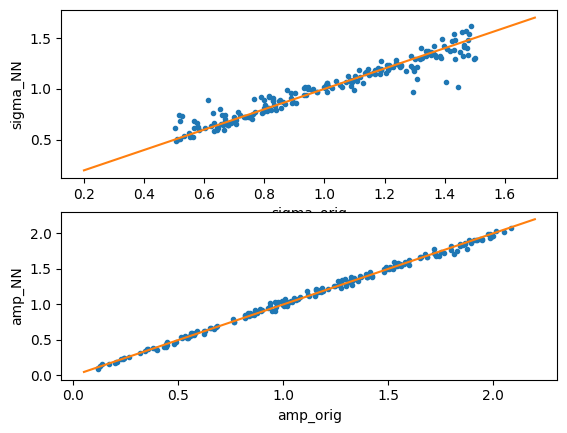

In [ ]:
deepnet.model.eval()

x = np.linspace(-5.0, 5.0, 100)
sigma = 1.0 * np.random.rand(200) + 0.5
amplitude = 2.0 * np.random.rand(200) + 0.1
y = amplitude[:,None] * np.exp(-x[None,:]**2 / sigma[:,None]**2) + 0.05 * np.random.randn(200, 100)

with torch.no_grad():

    inputs = torch.tensor(y.astype('float32')).to(deepnet.device)

    out = deepnet.model(inputs).cpu()

f, ax = pl.subplots(nrows=2, ncols=1)
ax[0].plot(sigma, out[:,0], '.')
ax[0].plot([0.2,1.7], [0.2,1.7])
ax[1].plot(amplitude, out[:,1], '.')
ax[1].plot([0.05,2.2], [0.05,2.2])

ax[0].set_xlabel('sigma_orig')
ax[0].set_ylabel('sigma_NN')
ax[1].set_xlabel('amp_orig')
ax[1].set_ylabel('amp_NN')
pl.show()

<figure>
<center>
<img width="400" src='https://miro.medium.com/v2/resize:fit:4800/format:webp/1*BgPLcocaAsS0AH2fEWlNmA.png' />
</center>
</figure>

**Redo the experiment by adding random velocities and building a neural network that also estimates them.**